# LightWeightMMM **DEMO**
#### This demo is for a practical presentation to tackle a data challenge of [link text](https://)Marketing Analytics

In [ ]:
# First would be to install lightweight_mmm
!pip install --upgrade git+https://github.com/google/lightweight_mmm.git

In [84]:
# Import jax.numpy and any other library we might need.
import jax.numpy as jnp
import numpyro
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [85]:
# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

### Organising the data for modelling

In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
csv="/content/drive/MyDrive/Practicum Data.csv"
df=pd.read_csv(csv) #, index_col=0)
df

,DATE,DEMAND,Consumer Price Index (CPI),Consumer Confidence Index(CCI),Producer Price Index (PPI),Unit Price ($),POS/ Supply Data,SALES ($),Advertising Expenses (SMS),Advertising Expenses(Newspaper ads),Advertising Expenses(Radio),Advertising Expenses(TV),Advertising Expenses(Search Engine),GRP (NewPaper ads),GRP(SMS),GRP(Radio,GRP(Search Engine),GRP(TV)
0,1/1/2010,4384,104.9,96.3,106.7,361.62,4240,1533268.80,77.4819,14.10419,112.3370,1479.457,722.571,95.333,11.8398,91.0000,276.3636,756.5909
1,1/2/2010,4366,104.9,96.3,106.7,361.62,4266,1542670.92,73.4783,13.29876,105.7133,1369.891,717.857,114.957,27.8039,111.9091,291.3182,860.1364
2,1/3/2010,4006,104.9,96.3,106.7,361.62,4206,1520973.72,80.6093,13.20069,108.7702,1428.065,653.333,113.090,0.0000,94.6364,282.7273,751.9545
3,1/4/2010,4076,104.9,96.3,106.7,361.62,4176,1510125.12,65.9319,12.72143,93.3065,1309.355,622.095,72.442,0.0000,98.5909,306.3182,749.4545
4,1/5/2010,4834,104.9,96.3,106.7,361.62,5234,1892719.08,77.4819,14.10419,112.3370,1479.457,722.571,95.333,11.8398,91.0000,276.3636,756.5909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2608,2/21/2017,7312,101.4,100.3,103.3,361.62,6974,2521937.88,60.6667,13.48886,76.7250,1399.662,4168.952,272.036,0.0000,93.9545,222.7727,805.9091
2609,2/22/2017,6456,101.4,100.3,103.3,361.62,6123,2214199.26,59.1026,13.20659,78.6058,1369.349,3984.429,817.581,31.3919,81.9091,225.1818,816.2727
2610,2/23/2017,6060,101.4,100.3,103.3,361.62,5989,2165742.18,61.1351,12.77514,76.2872,1341.730,3943.524,1288.844,31.1817,98.6818,224.5455,855.8636
2611,2/24/2017,5980,101.4,100.3,103.3,361.62,5877,2125240.74,53.7865,12.94013,74.9424,1323.553,5732.000,540.757,31.5487,111.0455,232.8636,791.3636


In [ ]:
##df.to_csv("/content/drive/MyDrive/Weekly Practicum Data.csv")

In [ ]:
df.info()

In [89]:
#Convert object DATE to datetime object
df['DATE']=pd.to_datetime(df['DATE'])

In [ ]:
df.info()

In [90]:
# Rename columns
df.rename(columns={'Consumer Price Index (CPI)': 'CPI', 'Consumer Confidence Index(CCI)': 'CCI', 'Producer Price Index (PPI)':'PPI', 'SALES ($)':'SALES','Unit Price ($)':'Unit_Price','POS/ Supply Data':'Supply','Advertising Expenses (SMS)':'SMS_Cost','Advertising Expenses(Newspaper ads)':'Newspaper_Cost','Advertising Expenses(Radio)':'Radio_Cost','Advertising Expenses(TV)':'TV_Cost','Advertising Expenses(Search Engine)':'SEM_Cost','GRP (NewPaper ads)':'Newspaper_GRP','GRP(SMS)':'SMS_GRP','GRP(Radio':'Radio_GRP','GRP(Search Engine)':'SEM_GRP','GRP(TV)':'TV_GRP'},inplace=True )

In [ ]:
# df['Potential_Revenue'] = df['DEMAND'] * df['Unit_Price']

In [91]:
df.set_index('DATE', inplace=True)

### Aggregate Daily Data to Weekly Data

In [92]:
# First, let's check the count of days per week
week_counts = df.resample('W').count()
# Identify weeks with full 7 days
full_weeks = week_counts[week_counts['DEMAND'] == 7].index
# Aggregate the daily data to weekly, taking the SUM (you can choose your own aggregation method)
weekly_df = df.resample('W').agg({
    'DEMAND': 'sum',
    'Supply': 'sum',
    'SALES': 'sum',
    'Unit_Price': 'mean',
    'SMS_Cost': 'sum',
    'Newspaper_Cost': 'sum',
    'Radio_Cost': 'sum',
    'TV_Cost': 'sum',
    'SEM_Cost': 'sum',
    'Newspaper_GRP': 'sum',
    'SMS_GRP': 'sum',
    'Radio_GRP': 'sum',
    'TV_GRP': 'sum',
    'SEM_GRP': 'sum',
    'CPI': 'mean',
    'CCI': 'mean',
    'PPI': 'mean'
})
# Keep only full weeks
Weekly_df_f= weekly_df[weekly_df.index.isin(full_weeks)]

df=Weekly_df_f

In [ ]:
# Filtering out data for years not equal to 2013, 2014, and 2015
# excluded_years = [2013, 2014, 2015, 2017]
# df = df[~df.index.year.isin(excluded_years)]

In [93]:
df.head()

,DEMAND,Supply,SALES,Unit_Price,SMS_Cost,Newspaper_Cost,Radio_Cost,TV_Cost,SEM_Cost,Newspaper_GRP,SMS_GRP,Radio_GRP,TV_GRP,SEM_GRP,CPI,CCI,PPI
DATE,,,,,,,,,,,,,,,,,
2010-01-10,31864,32584,11783026.08,361.62,521.9711,92.42044,722.6765,9647.475,4573.903,594.148,39.6437,707.7728,5398.4999,2075.4545,104.9,96.3,106.7
2010-01-17,36801,37681,13626203.22,361.62,515.4188,92.80538,709.9899,9809.145,4413.953,808.051,315.7284,853.4999,5949.4091,2028.3181,104.9,96.3,106.7
2010-01-24,53233,54773,19807012.26,361.62,493.0872,92.65789,688.2157,9765.169,27220.714,930.452,185.9576,787.2272,6821.4091,1972.4090,104.9,96.3,106.7
2010-01-31,74417,72158,26093775.96,361.62,533.0035,95.11051,729.1392,10048.562,19774.524,921.082,326.8087,775.2272,6674.9547,1802.9090,104.9,96.3,106.7
2010-02-07,77841,72326,26154528.12,361.62,520.5133,94.25018,725.8307,10008.072,23495.907,1040.798,105.7985,597.9545,5901.9546,1564.8182,104.9,96.5,107.2


# Descriptive Analysis
## Data Exploring

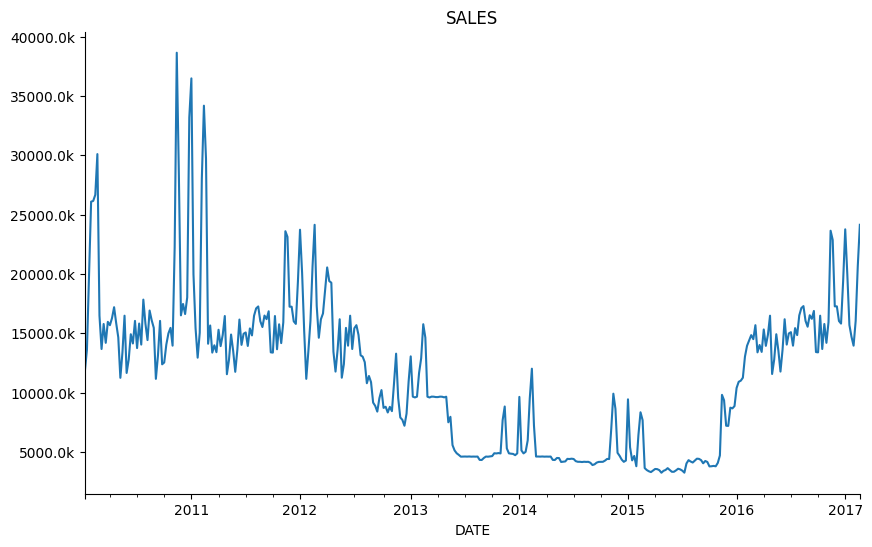

In [135]:
# @title SALES Over Time
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter


# Function to format the y-axis tick labels
def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.1fk' % (x * 1e-3)

formatter = FuncFormatter(thousands)

# Plotting (assuming your DataFrame plotting part goes here)
fig, ax = plt.subplots(figsize=(10, 6))
df[ 'SALES'].plot(kind='line', ax=ax, title='SALES')
ax.yaxis.set_major_formatter(formatter)

# Customizing the spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.show()

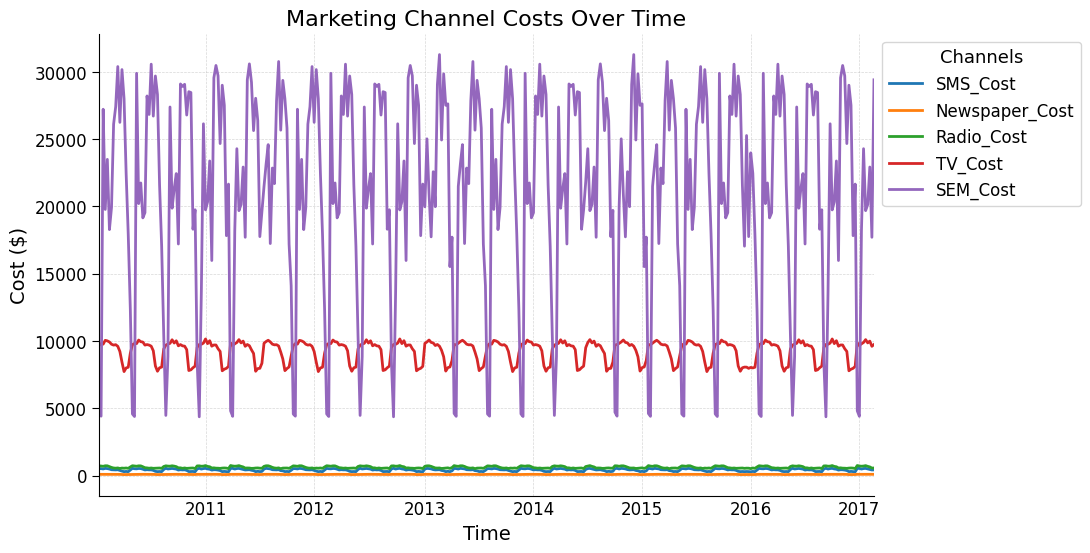

In [99]:
# @title Marketing Channel Costs Over Time

# Assuming df is your DataFrame
# Example plotting command
df[['SMS_Cost', 'Newspaper_Cost', 'Radio_Cost', 'TV_Cost', 'SEM_Cost']].plot(
    kind='line',
    figsize=(10, 6),  # Slightly larger for better readability
    linewidth=2,  # Thicker lines
    title='Marketing Channel Costs Over Time'
)

# Improve legibility
plt.title('Marketing Channel Costs Over Time', fontsize=16)
plt.xlabel('Time', fontsize=14)  # Assuming the index of df represents time
plt.ylabel('Cost ($)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Enhance the legend
plt.legend(title='Channels', fontsize=12, title_fontsize=13, loc='upper left', bbox_to_anchor=(1, 1))

# Simplify the graph
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().xaxis.set_tick_params(which='both', size=0)
plt.gca().yaxis.set_tick_params(which='both', size=5)  # Minimalistic ticks

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)  # Light grid to aid readability without clutter

# Optional: Customize color and style for each line if needed using the 'color' and 'style' parameters.

plt.show()

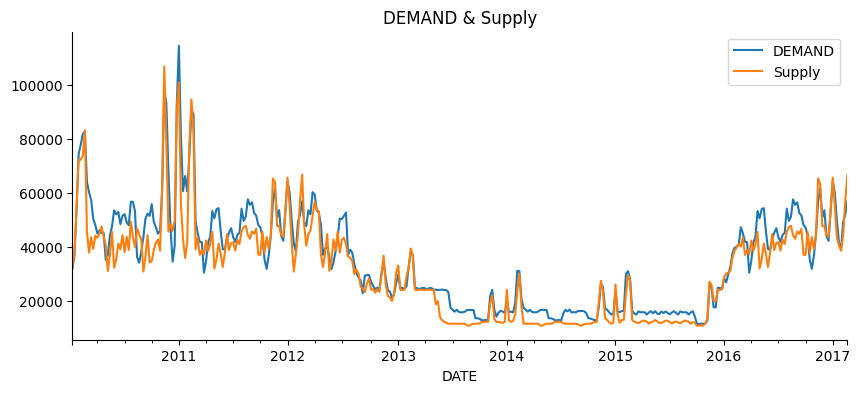

In [100]:
# @title DEMAND & Supply
df[['DEMAND','Supply']].plot(kind='line', figsize=(10, 4), title='DEMAND & Supply')
plt.gca().spines[['top', 'right']].set_visible(False)

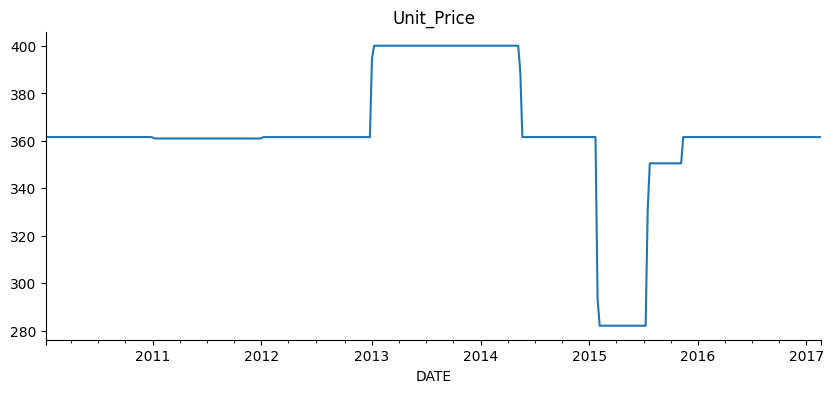

In [101]:
# @title Unit_Price

from matplotlib import pyplot as plt
df['Unit_Price'].plot(kind='line', figsize=(10, 4), title='Unit_Price')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
df.info()

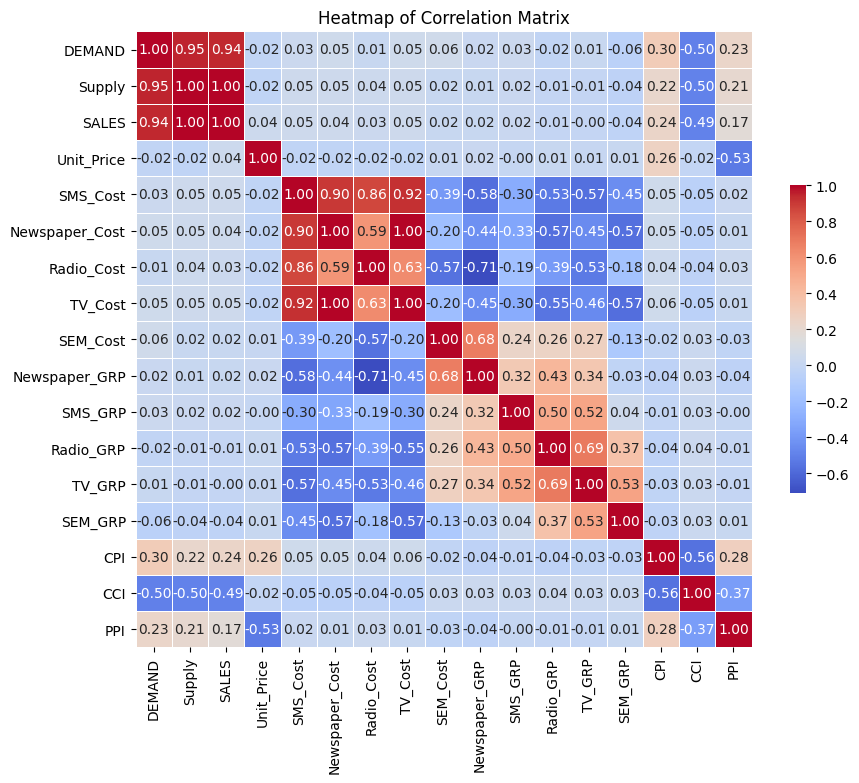

In [109]:
# @title Heatmap of Correlation Matrix

# Calculate the correlation matrix
# df1=df[['SALES','DEMAND','Supply','SMS_Cost','Newspaper_Cost','Radio_Cost','TV_Cost','SEM_Cost','CPI','CCI','PPI']]
correlation_matrix = df.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))  # Optional: Adjust figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt=".2f",
            cbar_kws={'shrink': .5}, square=True)

plt.title('Heatmap of Correlation Matrix')
plt.show()

# Modeling

In [145]:
# @title Define Data
media_data = df[['SMS_Cost','Newspaper_Cost','Radio_Cost','TV_Cost', 'SEM_Cost']].to_numpy()
costs = df[['SMS_Cost','Newspaper_Cost','Radio_Cost','TV_Cost', 'SEM_Cost']].sum().to_numpy()
target = df['SALES'].to_numpy()
extra_features = df[['CPI','CCI','PPI','DEMAND']].to_numpy()

In [111]:
# @title Set 10% data for training
data_size=len(target)
train_size=int(data_size*0.1)

In [112]:
# @title Feature Split
# Split and scale data.
split_point = data_size - train_size
# Media data
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]
# Extra features
extra_features_train = extra_features[:split_point, ...]
extra_features_test = extra_features[split_point:, ...]
# Target
target_train = target[:split_point]

### Feature Scaling
In this demo we divide the data on media, extra features and the target by their mean to ensure that the result has a mean of 1. This allows the model to be agnostic to the scale of the inputs (e.g. a user can use either the number of sales or the value of sales). The costs are not used in the model directly, they are only used to inform the prior distributions on the media variables (see the [model documentation here](https://lightweight-mmm.readthedocs.io/en/latest/models.html)). These costs have been scaled down by multiplying by 0.15 to reflect typical ranges in MMMs.

In [113]:
#Feature Scaling
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean, multiply_by=0.15)

media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

###Checking the variances

The below cell shows the variance of each feature over time. Variances which are lower than the specified low_variance_threshold or higher than the specified high_variance_threshold are marked in red. Make sure you are passing the scaled versions of your media_data and extra_features_data to the data quality checker for these variances before running this check!

In [114]:

correlations, variances, spend_fractions, variance_inflation_factors = preprocessing.check_data_quality(
    media_data=media_scaler.transform(media_data),
    target_data=target_scaler.transform(target),
    cost_data=costs,
    extra_features_data=extra_features_scaler.transform(extra_features))


In [ ]:
def highlight_variances(x: float,
                        low_variance_threshold: float=1.0e-3,
                        high_variance_threshold: float=3.0) -> str:

    if x < low_variance_threshold or x > high_variance_threshold:
      weight = 'bold'
      color = 'red'
    else:
      weight = 'normal'
      color = 'black'
    style = f'font-weight: {weight}; color: {color}'
    return style

variances.style.format(precision=4).applymap(highlight_variances)

In [ ]:

def highlight_high_vif_values(x: float,
                              high_vif_threshold: float=7.0) -> str:
    if x > high_vif_threshold:
      weight = 'bold'
      color = 'red'
    else:
      weight = 'normal'
      color = 'black'
    style = f'font-weight: {weight}; color: {color}'
    return style

variance_inflation_factors.style.format(precision=4).applymap(highlight_high_vif_values)

#Training the model
The currently available models are the following:

*   hill_adstock
*   adstock
*   carryover

In [117]:
mmm = lightweight_mmm.LightweightMMM(model_name="carryover")

number_warmup=1000
number_samples=1000

In [118]:
mmm.fit(
    media=media_data_train,
    media_prior=costs,
    target=target_train,
    extra_features=extra_features_train,
    number_warmup=number_warmup,
    number_samples=number_samples,
    )

/usr/local/lib/python3.10/dist-packages/lightweight_mmm/lightweight_mmm.py:359: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|██████████| 2000/2000 [15:17<00:00,  2.18it/s, 1023 steps of size 4.09e-03. acc. prob=0.96]


You can check the summary of your trace by printing a summary:

In [119]:
mmm.print_summary()


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
ad_effect_retention_rate[0]      0.49      0.28      0.48      0.02      0.91   3208.56      1.00
ad_effect_retention_rate[1]      0.51      0.29      0.50      0.11      1.00   3561.38      1.00
ad_effect_retention_rate[2]      0.49      0.29      0.48      0.00      0.90   3806.64      1.00
ad_effect_retention_rate[3]      0.42      0.27      0.38      0.00      0.82   2428.53      1.00
ad_effect_retention_rate[4]      0.53      0.22      0.56      0.16      0.85   1553.55      1.00
     coef_extra_features[0]     -1.05      0.66     -1.03     -2.16      0.00   1774.46      1.00
     coef_extra_features[1]      0.08      0.38      0.08     -0.57      0.64   1990.30      1.00
     coef_extra_features[2]     -1.07      0.46     -1.06     -1.83     -0.34   2335.49      1.00
     coef_extra_features[3]      0.97      0.03      0.97      0.93      1.01   2337.22      1.00
              coef_

In [ ]:
# Naming the cols
mdsp_cols = ['SMS_Cost','Newspaper_Cost','Radio_Cost','TV_Cost', 'SEM_Cost']
mdsp_cols

We can visualise the posterior distributions of the media effects:

In [ ]:
plot.plot_media_channel_posteriors(media_mix_model=mmm,channel_names=mdsp_cols)

One can also check your model's fit to the training data.

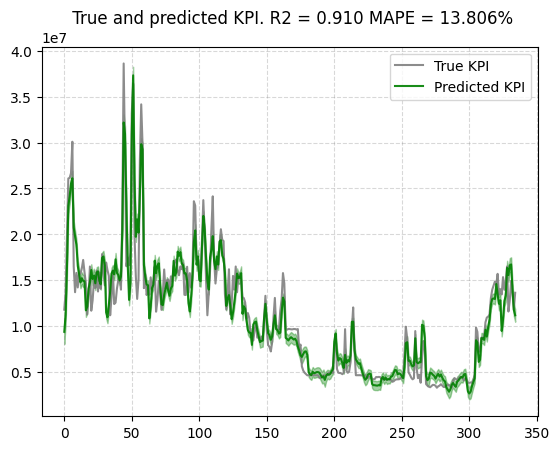

In [122]:
plot.plot_model_fit(mmm, target_scaler=target_scaler)

In [123]:
#plot.plot_prior_and_posterior(media_mix_model=mmm)

#Media insights


In [124]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

We can quickly visualise the estimated media & baseline contribution over time

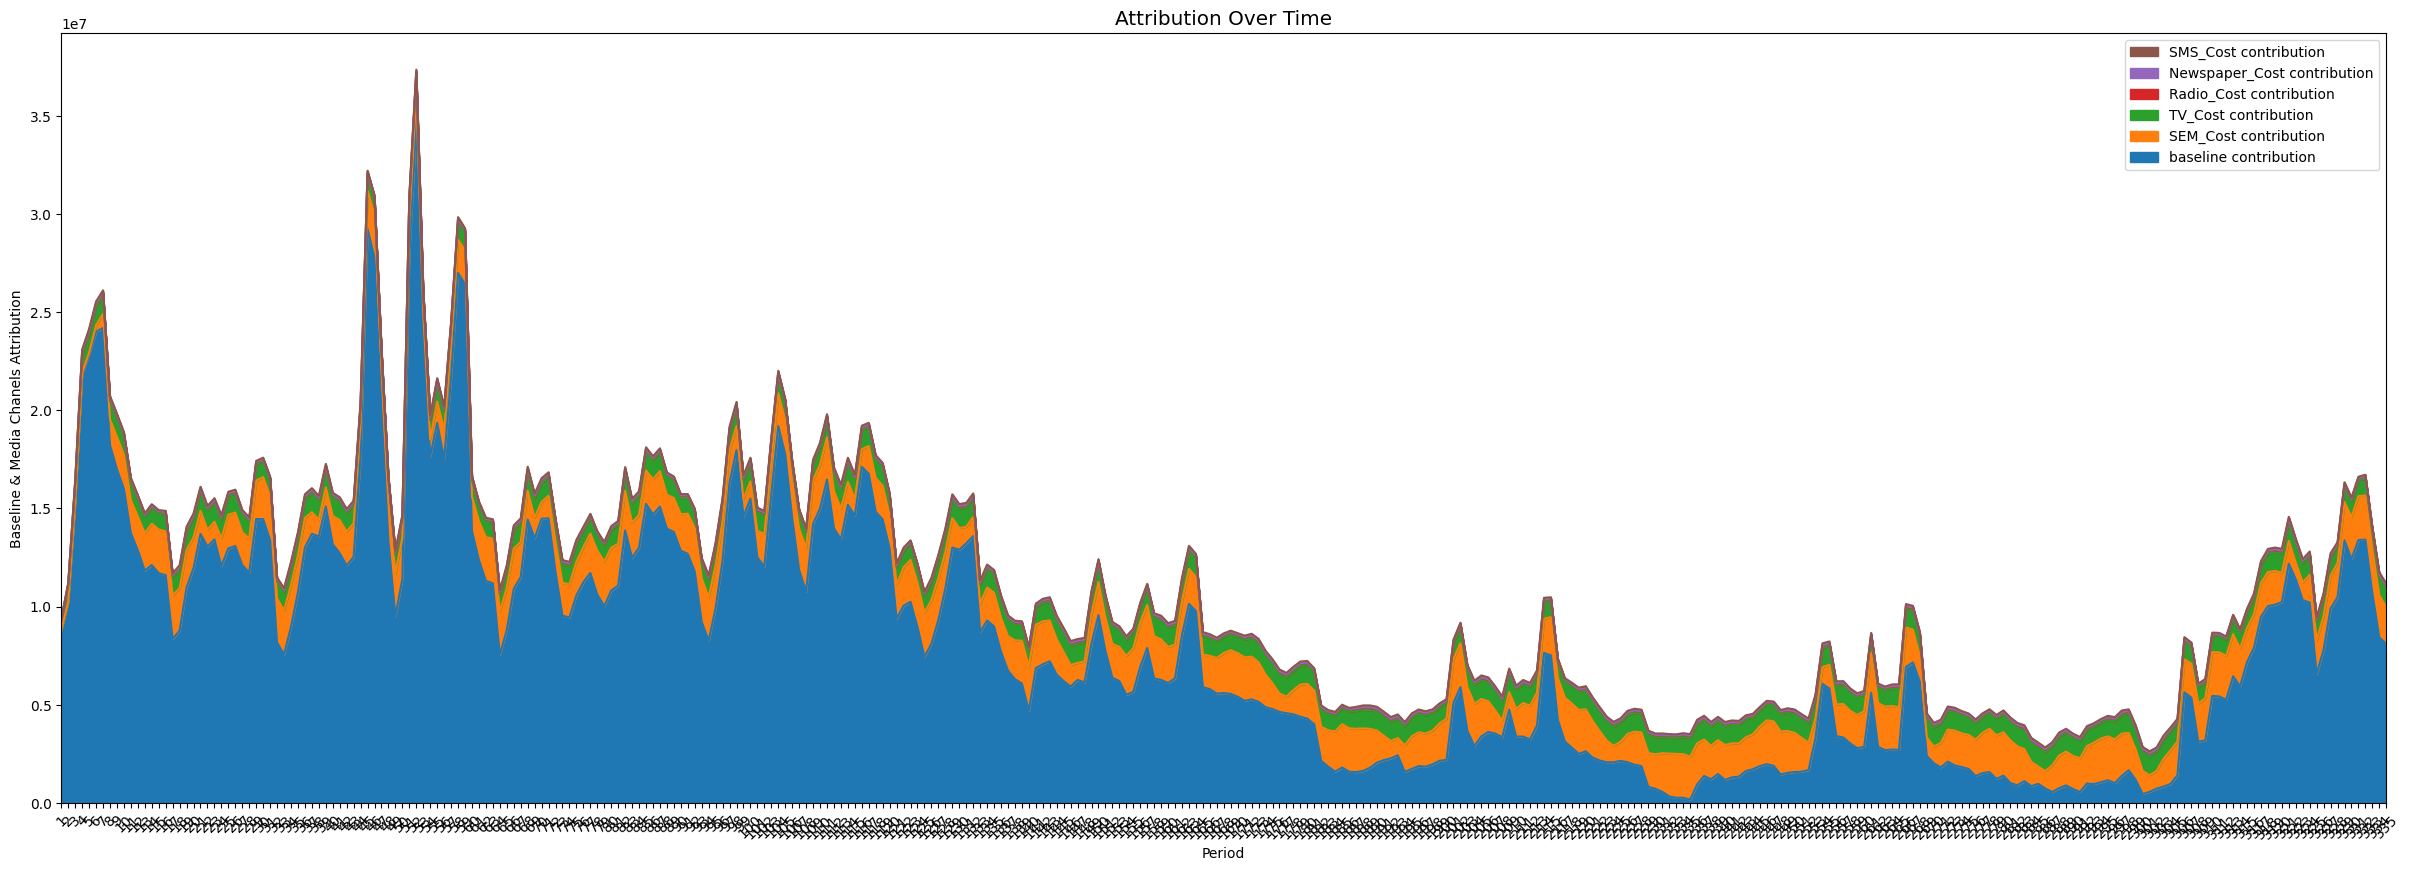

In [125]:
plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(30,10),channel_names=mdsp_cols)

We can quickly visualise the estimated media contributions with their respective credibility intervals

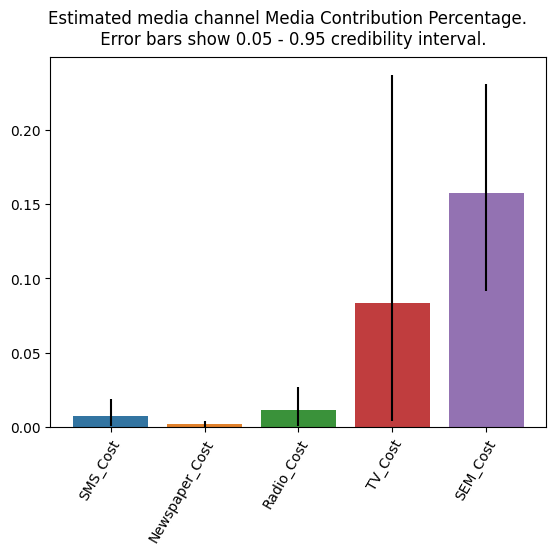

In [126]:
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage",channel_names=mdsp_cols)


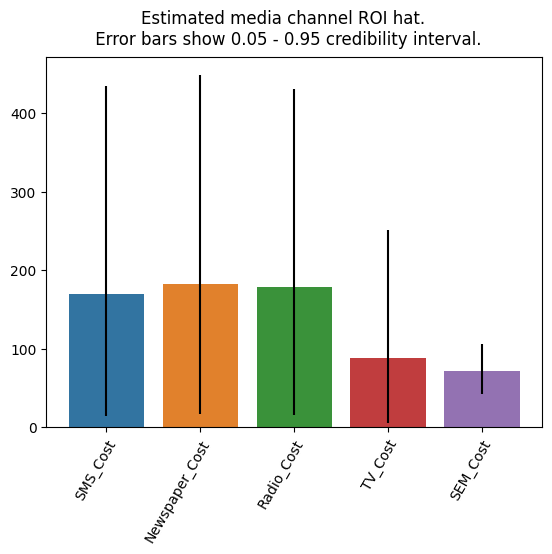

In [127]:
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat",channel_names=mdsp_cols)

Another vital question we can solve with MMMs is how each media channel behaves individually as we invest more in it.

For that we can plot the curve response of all media channels with the following function:

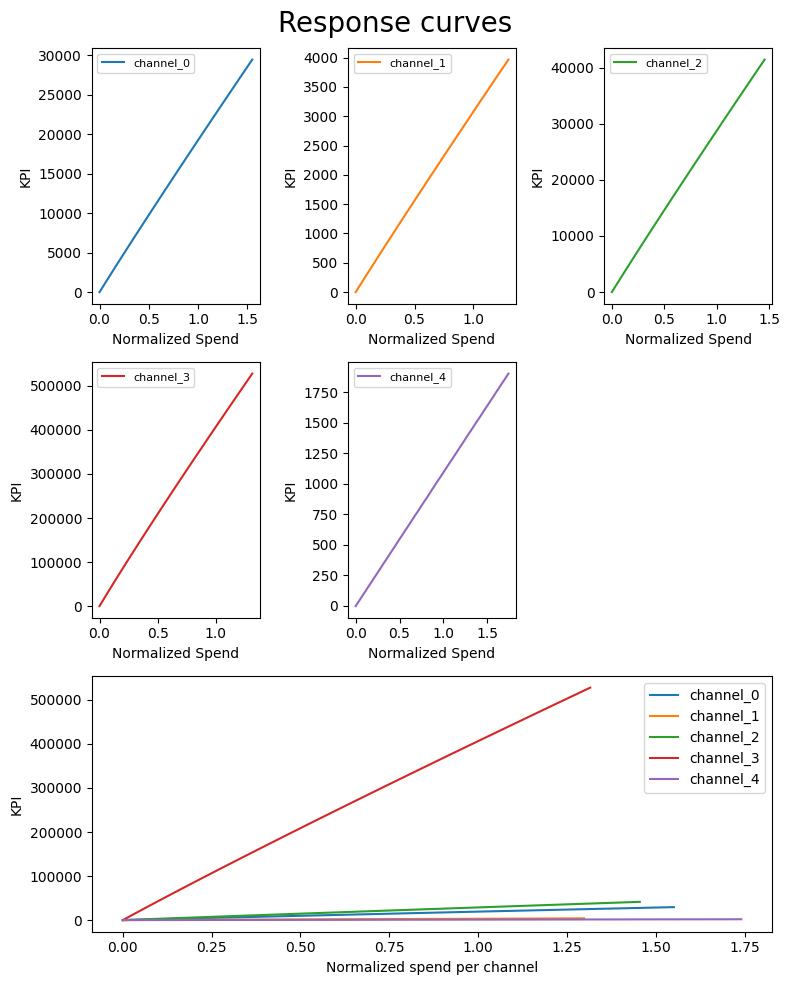

In [128]:
plot.plot_response_curves( media_mix_model=mmm, target_scaler=target_scaler)

#Optimization
The optimization is meant to solve the budget allocation questions for you. First you need to provide for how long you want to optimize your budget (eg. 10 weeks in this case).

The optimization values will be bounded by +- 20% of the max and min historic values used for training. Which means the optimization won't recommend to completely change your strategy but how to make some budget re-allocation.

You can change that percentage with the following parameters:

bounds_lower_pct
bounds_upper_pct
Which can hold 1 value for all channels or 1 value per channel.

Prices are the average price you would expect for the media units of each channel. If your data is already in monetary units (eg. $) your prices should be an array of 1s.

In [141]:
prices = jnp.ones(mmm.n_media_channels)
# The budget is how much one would like to allocate throughtout the total of n_time_periods. Make sure this amount is inline with the historic spend or otherwise some conditions/bounds in the optimization might not be met.

n_time_periods = 12
budget = jnp.sum(jnp.dot(prices, media_data.mean(axis=0)))* n_time_periods

In [142]:
# Run optimization with the parameters of choice.
solution, kpi_without_optim, previous_budget_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -249228813.4024433
            Iterations: 14
            Function evaluations: 143
            Gradient evaluations: 13


In [143]:
# Obtain the optimal weekly allocation.
optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

Array([  6071.246 ,   1273.6328,   8869.335 , 133332.23  , 233854.61  ],      dtype=float32)

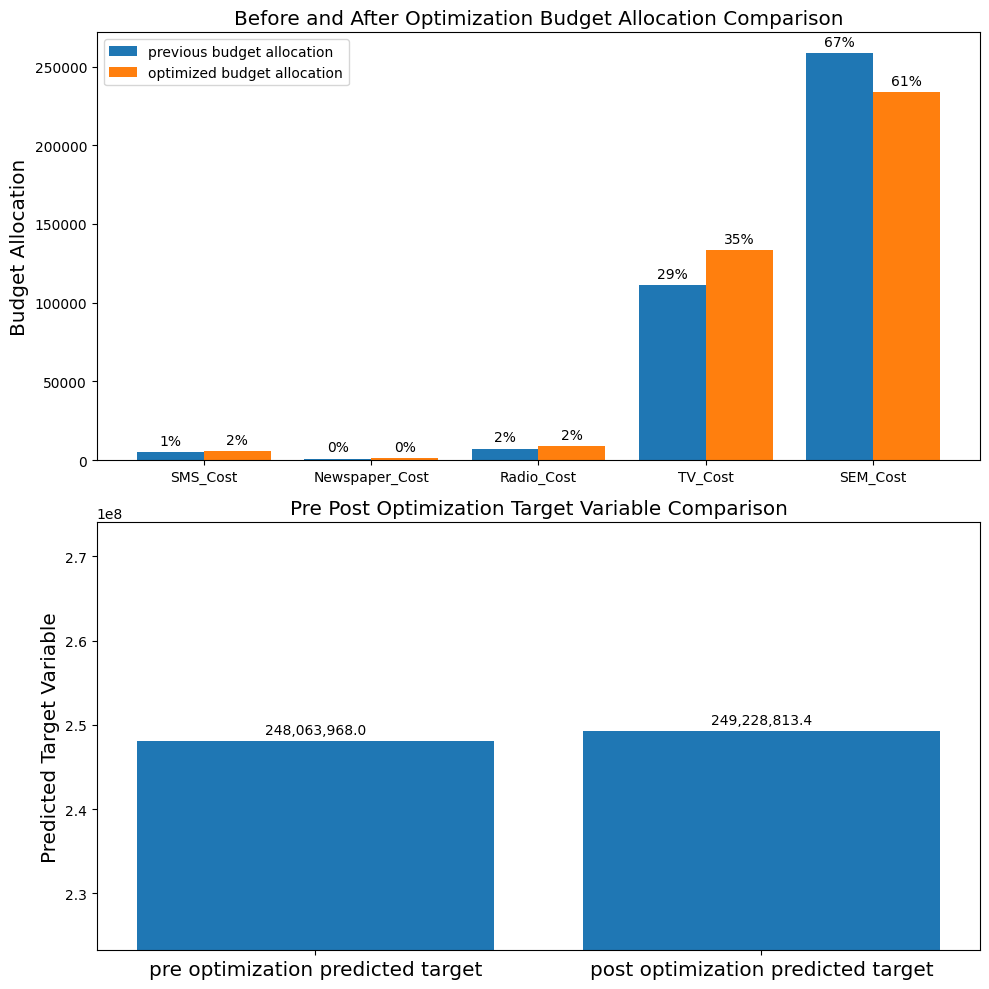

In [144]:
# Plot out pre post optimization budget allocation and predicted target variable comparison.
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm,
                                                kpi_with_optim=solution['fun'],
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation,
                                                previous_budget_allocation=previous_budget_allocation,
                                                figure_size=(10,10),channel_names=mdsp_cols)